## **1. Background Image Calculation Using Median and Mode Filtering with Dask Optimization**

### Purpose:
This section of the code calculates a background image from a series of TIFF images using a combination of **median** and **mode filtering**. It leverages **Dask** for speed optimization, which enables handling large image datasets by processing them in parallel. The final background image is converted into a 12-bit TIFF format using **ImageMagick** for efficient storage and further use.

### Warning:
⚠️ **Note**: Due to the large number of images and the use of advanced filtering techniques, this computation may take a considerable amount of time, especially if thousands of images are processed. Please be patient and ensure that your system has sufficient memory and processing power for large datasets.

### Key Features:
- **Efficient Data Handling**: Dask allows for parallel processing of images, significantly speeding up operations on large datasets.
- **Median and Mode Filtering**: The median removes transient objects, while the mode corrects for outliers and residual artifacts, resulting in a clean and reliable background image.
- **12-bit TIFF Conversion**: The final background image is saved in 12-bit format using ImageMagick, ensuring optimal file size while preserving necessary details.

### Explanation:
1. **Retrieve TIFF Files**: The code looks for TIFF files in the specified folder that start with 'F' and prepares them for processing.
2. **Background Calculation**:
   - **Median Filtering**: Dask computes the median pixel value across all images to estimate the background.
   - **Outlier Removal**: Outliers (pixels that deviate from the median) are identified and ignored in further calculations.
   - **Mode Calculation**: The mode is used to handle any remaining noise and refine the background.
3. **Conversion to 12-bit TIFF**: The background image is saved as a 16-bit TIFF temporarily and then converted to 12-bit using ImageMagick, optimizing the file size.
4. **Visualization**: The final background image is displayed for review.

### Final Output:
The background image is saved in the base directory as `BackgroundImage.tif`.



Loading TIFF Images: 100%|███████████████████████████████████████████████████████| 10914/10914 [03:10<00:00, 57.17it/s]


12-bit TIFF background image saved successfully at C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\13 - Data Analysis codes\02 - DepthMapWithShapeRepair\BackgroundImage.tif.


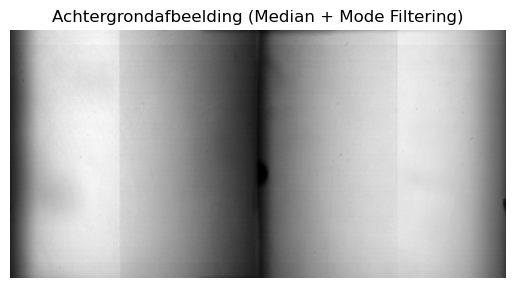

In [2]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from scipy import stats
import dask.array as da
import subprocess
from tqdm import tqdm  # Progress bar library

# Function to retrieve TIFF files from the folder
def get_tiff_files(folder_path):
    return sorted([f for f in os.listdir(folder_path) if f.endswith('.tif') and f.startswith('F')])

# Function to calculate background using median filtering with mode calculation and Dask for speed optimization
def calculate_background_with_dask(tiff_folder, base_directory, threshold=500):
    tiff_files = get_tiff_files(tiff_folder)
    
    if not tiff_files:
        print("Geen TIFF-bestanden gevonden in de map.")
        return
    
    num_files_to_use = len(tiff_files)  # Use all available files
    
    # Load images into a 3D Dask array (height, width, num_files_to_use) with progress bar
    sample_image = tiff.imread(os.path.join(tiff_folder, tiff_files[0])).astype(np.float32)
    height, width = sample_image.shape
    images = da.stack([da.from_array(tiff.imread(os.path.join(tiff_folder, tiff_files[i])), chunks=(height, width)) 
                       for i in tqdm(range(num_files_to_use), desc="Loading TIFF Images")])

    # Median filtering: Take the median of all images at each pixel using Dask
    median_background = da.median(images, axis=0).compute()

    # Outlier filtering: Ignore pixels that deviate too much from the median
    mask = da.abs(images - median_background) > threshold
    filtered_images = da.where(mask, np.nan, images)
    
    # Recalculate the background using the mean of non-outlier values
    background = da.nanmean(filtered_images, axis=0).compute()
    
    # Calculate the mode to remove remaining artifacts
    mode_background = stats.mode(images.compute(), axis=0, nan_policy='omit')[0].squeeze()

    # Combine the mode and the median background
    final_background = np.where(np.isnan(background), mode_background, background)

    # Scale the 12-bit data (0-4095) to 16-bit (0-65535) for ImageMagick conversion
    final_background_16bit = (final_background * 16).astype(np.uint16)

    # Define paths for temporary 16-bit and final 12-bit images
    temp_background_image_path = os.path.join(base_directory, "Temp_BackgroundImage.tif")
    final_background_image_path = os.path.join(base_directory, "BackgroundImage.tif")

    # Save the background image as a 16-bit TIFF temporarily using tifffile
    tiff.imwrite(temp_background_image_path, final_background_16bit, resolution=(96, 96))  # Set resolution to 96 dpi

    # Use ImageMagick to convert the 16-bit TIFF to 12-bit
    command = rf'"C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe" "{temp_background_image_path}" -depth 12 -define tiff:rows-per-strip=5 "{final_background_image_path}"'

    # Execute the ImageMagick command to convert to 12-bit
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    stdout, stderr = process.communicate()

    # Print the result of ImageMagick processing
    if os.path.exists(final_background_image_path):
        print(f"12-bit TIFF background image saved successfully at {final_background_image_path}.")
    else:
        print(f"ImageMagick conversion failed. Error Output:\n", stderr.decode('utf-8'))

    # Remove the temporary 16-bit image
    if os.path.exists(temp_background_image_path):
        os.remove(temp_background_image_path)

    # Display the final background image
    plt.imshow(final_background, cmap='gray')
    plt.title("Achtergrondafbeelding (Median + Mode Filtering)")
    plt.axis('off')
    plt.show()

    return final_background_image_path

# Define the path to the folder with TIFF files
base_directory = os.getcwd()
tiff_folder = os.path.join(base_directory, "Temporary copy of original recording")

# Calculate and display the background image using median filtering with mode and Dask for speed
background_image_path = calculate_background_with_dask(tiff_folder, base_directory, threshold=1000)


## **2. Random Test Background Subtraction and Ratio-Based Shadow Correction for 12-bit Images**

### Purpose:
This code performs a **random background subtraction** and **ratio-based shadow correction** on a randomly chosen 12-bit TIFF image. The aim is to enhance foreground objects while correcting for shadows in the image. The process leverages background subtraction, thresholding, and ratio-based correction to refine the image quality.

### Key Features:
1. **Random Image Selection**:
   - A random TIFF image is selected from the folder for background subtraction.

2. **Background Subtraction**:
   - The background image is subtracted from the randomly selected image to isolate foreground objects (bubbles).
   - A threshold is applied to remove noise, ensuring only the relevant parts of the image are retained.

3. **Ratio-Based Shadow Correction**:
   - A ratio correction is applied to mitigate shadow effects in the image by dividing the random image by the background, while avoiding division by zero.
   - This enhances the contrast and makes the foreground clearer.

4. **Visualization**:
   - The code displays four images for comparison:
     1. Original random image (converted to 16-bit).
     2. Background image (converted to 16-bit).
     3. Result of the background subtraction with a threshold.
     4. Image after applying ratio-based shadow correction.

### Explanation of Process:
1. **TIFF Image Handling**: 
   - Both the random image and the background image are read as 12-bit images and converted to 16-bit for further processing.
   
2. **Background Subtraction**: 
   - The background is subtracted from the random image, and a threshold is applied to retain only the significant pixel values, which are likely to be foreground objects.

3. **Ratio-Based Shadow Correction**:
   - To further enhance the foreground, the random image is divided by the background to reduce shadowing effects, ensuring better visibility of the objects.

### Output:

- The code generates a set of images showing the different stages of background subtraction and correction, allowing you to visually compare the results.



Max pixel value in random image (16-bit): 47440
Max pixel value in background image (16-bit): 47360


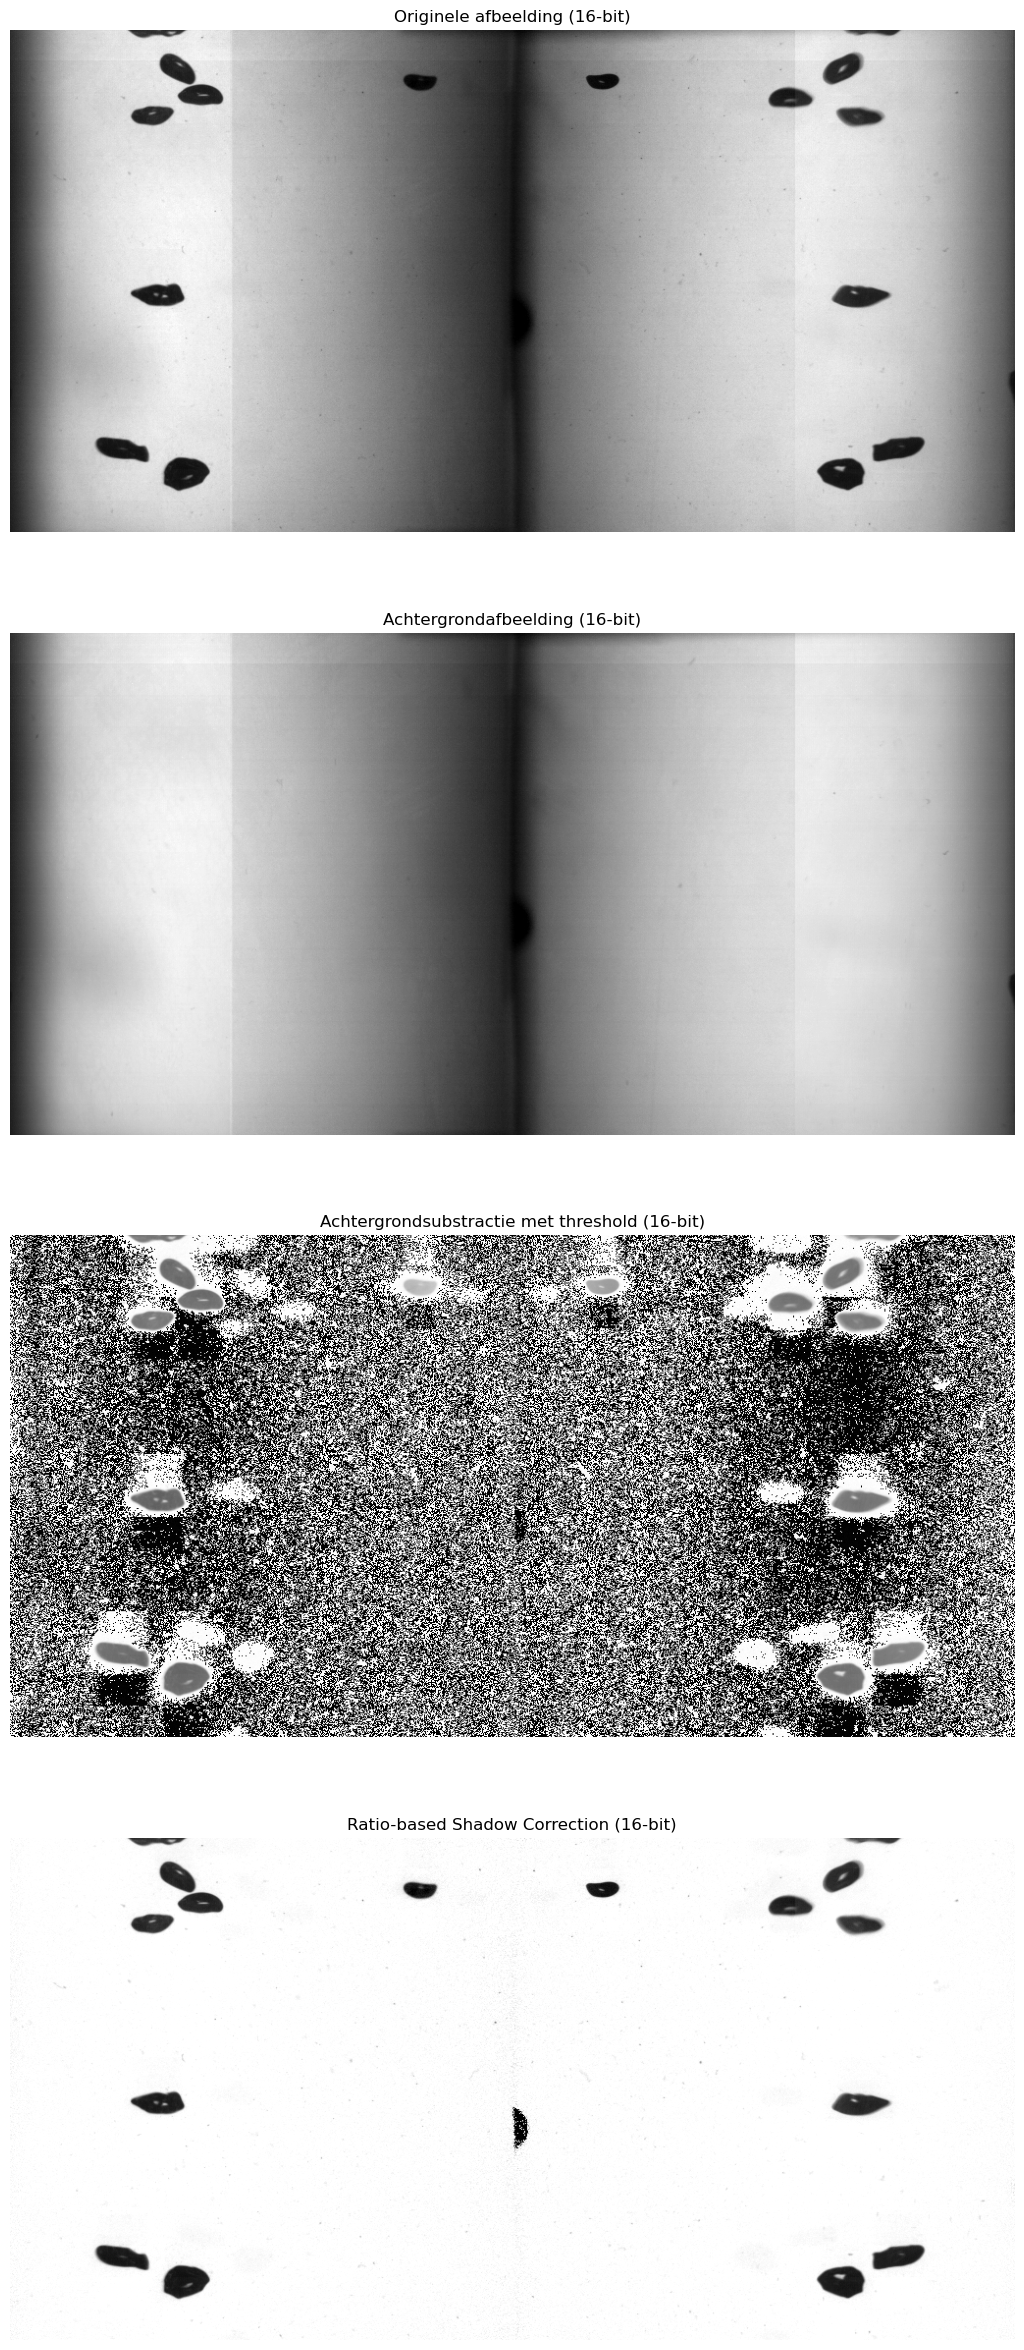

In [11]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import random

# Function to retrieve TIFF files
def get_tiff_files(tiff_folder):
    return [f for f in os.listdir(tiff_folder) if f.endswith('.tif')]

# Function to perform random background subtraction and ratio-based shadow correction for 12-bit images
def random_background_subtraction(tiff_folder, base_directory, threshold_value=10):
    tiff_files = get_tiff_files(tiff_folder)
    
    if not tiff_files:
        print("Geen TIFF-bestanden gevonden in de map.")
        return
    
    # Choose a random image
    random_image_file = random.choice(tiff_files)
    random_image_path = os.path.join(tiff_folder, random_image_file)
    
    # Path to the previously generated background image in the base_directory
    background_image_path = os.path.join(base_directory, "BackgroundImage.tif")
    
    # Read the random image and the background (both 12-bit)
    random_image = tiff.imread(random_image_path)
    background_image = tiff.imread(background_image_path)
    
    # Convert the 12-bit images (max value 4095) to 16-bit (max value 65535)
    random_image_16bit = (random_image.astype(np.uint32) * 16).astype(np.uint16)
    background_image_16bit = (background_image.astype(np.uint32) * 16).astype(np.uint16)
    
    # Find the lowest value in the image
    lowest_value = np.min(background_image_16bit)
    
    # Subtract the lowest value from the entire image
    background_image_16bit = (background_image_16bit - lowest_value).astype(np.uint16)

    # Check for the highest pixel values in both images
    max_random_image_value = np.max(random_image_16bit)
    max_background_image_value = np.max(background_image_16bit)
    
    print(f"Max pixel value in random image (16-bit): {max_random_image_value}")
    print(f"Max pixel value in background image (16-bit): {max_background_image_value}")
    
    # Perform background subtraction, clip to 16-bit range
    subtracted_image = np.clip(random_image_16bit - background_image_16bit, 0, 65535).astype(np.uint16)
    
    # Apply a threshold to retain only foreground objects
    thresholded_image = np.where(subtracted_image > (threshold_value * 16), subtracted_image, 0)
    
    # Perform ratio-based shadow correction (avoid division by zero)
    epsilon = 1e-5
    ratio_corrected_image = np.clip((random_image_16bit / (background_image_16bit + epsilon)) * 65535, 0, 65535).astype(np.uint16)
    
    # Display the original image, the background, the subtraction result, and the ratio correction
    fig, ax = plt.subplots(4, 1, figsize=(50, 30))
    ax[0].imshow(random_image_16bit, cmap='gray')
    ax[0].set_title("Originele afbeelding (16-bit)")
    ax[0].axis('off')
    
    ax[1].imshow(background_image_16bit, cmap='gray')
    ax[1].set_title("Achtergrondafbeelding (16-bit)")
    ax[1].axis('off')
    
    ax[2].imshow(thresholded_image, cmap='gray')
    ax[2].set_title("Achtergrondsubstractie met threshold (16-bit)")
    ax[2].axis('off')
    
    ax[3].imshow(ratio_corrected_image, cmap='gray')
    ax[3].set_title("Ratio-based Shadow Correction (16-bit)")
    ax[3].axis('off')
    
    plt.show()

# Define the path to the folder with TIFF files
base_directory = os.getcwd()
tiff_folder = os.path.join(base_directory, "Temporary copy of original recording")

# Perform random background subtraction
random_background_subtraction(tiff_folder, base_directory, threshold_value=10)






## **3. Batch Processing of TIFF Images with Ratio-Based Shadow Correction and 12-bit Conversion**

### Purpose:
This code processes multiple folders containing TIFF images by applying **ratio-based shadow correction** and converting the images from 16-bit back to 12-bit TIFF format using **ImageMagick**. It processes all folders that start with 'Fxxxxxx-Fxxxxxx' in the base directory, which are assumed to contain original TIFF images.

### Key Features:
1. **Ratio-Based Shadow Correction**:
   - Each TIFF image is divided by a background image, applying a ratio-based correction to remove shadow effects and enhance foreground objects.
   - The code ensures that the division does not lead to division by zero, using an epsilon value for safety.

2. **Batch Processing**:
   - The code identifies all folders with names starting with 'Fxxxxxx-Fxxxxxx', processes the TIFF images inside, and saves the corrected images in a subfolder named `Background subtracted images`.
   - The background subtraction process ensures only foreground objects are retained by applying a threshold.

3. **ImageMagick Conversion**:
   - After processing, each image is temporarily saved as a 16-bit TIFF, and then ImageMagick is used to convert the 16-bit image back to a 12-bit TIFF format, ensuring optimal storage while maintaining image quality.

4. **Automation**:
   - This code automates the process of background subtraction and conversion for multiple folders, streamlining the workflow for large datasets.

### Explanation of Process:
1. **TIFF File Handling**: 
   - The code reads the original images and the background image from their respective folders. The images are processed to apply shadow correction based on a ratio of the original image to the background.
   
2. **Thresholding**: 
   - A threshold is applied after ratio correction to remove noise and retain only the foreground, such as bubbles in the images.

3. **Image Conversion**: 
   - The corrected images are first saved as 16-bit TIFF files, then converted to 12-bit TIFF using ImageMagick for better compatibility and size optimization.

4. **Batch Folder Processing**: 
   - The code processes every folder starting with 'Fxxxxxx-Fxxxxxx' in the base directory, automatically applying the correction and conversion to all images inside.

### Output:
- Each processed folder contains a new subfolder named `Background subtracted images`, where the corrected and converted TIFF files are saved.


In [361]:
import os
import numpy as np
import tifffile as tiff
import subprocess

# Function to retrieve TIFF files from a specified folder
def get_tiff_files(folder_path):
    return sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

# Function to apply ratio-based shadow correction, save as a 16-bit image temporarily, and convert to 12-bit using ImageMagick
def process_and_save_images(tiff_folder, background_image, output_folder, threshold_value=10):
    tiff_files = get_tiff_files(tiff_folder)

    if not tiff_files:
        print(f"Geen TIFF-bestanden gevonden in {tiff_folder}.")
        return
    
    os.makedirs(output_folder, exist_ok=True)

    for tiff_file in tiff_files:
        tiff_path = os.path.join(tiff_folder, tiff_file)
        temp_image_path = os.path.join(output_folder, f"temp_{tiff_file}")
        output_image_path = os.path.join(output_folder, tiff_file)

        # Read the image (12-bit)
        image = tiff.imread(tiff_path).astype(np.uint16)

        # Perform ratio-based shadow correction (avoid division by zero)
        epsilon = 1e-5
        ratio_corrected_image = np.clip((image / (background_image + epsilon)) * 4095, 0, 4095).astype(np.uint16)

        # Apply a threshold to retain only foreground objects
        thresholded_image = np.where(ratio_corrected_image > (threshold_value * 16), ratio_corrected_image, 0).astype(np.uint16)

        # Ensure that the pixel values remain within the 12-bit range (0 to 4095)
        thresholded_image = np.clip(thresholded_image, 0, 4095).astype(np.uint16)

        # Scale 12-bit data to 16-bit range (multiply by 16 to get full range of 0-65535)
        thresholded_image_16bit = (thresholded_image * 16).astype(np.uint16)

        # Save the image as a 16-bit TIFF using tifffile 
        tiff.imwrite(temp_image_path, thresholded_image_16bit)

        # Now convert the 16-bit image to 12-bit using ImageMagick
        command = rf'"C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe" "{temp_image_path}" -depth 12 -define tiff:rows-per-strip=5 -units PixelsPerInch -density 96 "{output_image_path}"'
        
        # Execute the command and capture the output and errors
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
        stdout, stderr = process.communicate()


        # Remove the temporary image
        if os.path.exists(temp_image_path):
            os.remove(temp_image_path)

# Function to process all Fxxxxxx-Fxxxxxx folders
def process_all_folders(base_directory, background_image_path, threshold_value=10):
    folders = [f for f in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, f)) and f.startswith('F') and '-' in f]

    # Read the background image
    background_image = tiff.imread(background_image_path).astype(np.uint16)

    for folder in folders:
        original_images_folder = os.path.join(base_directory, folder, f"Original images {folder}")
        output_folder = os.path.join(base_directory, folder, f"Background subtracted images {folder}")

        if os.path.exists(original_images_folder):
            print(f"Processing folder: {original_images_folder}")

            # Apply ratio-based shadow correction and save images
            process_and_save_images(original_images_folder, background_image, output_folder, threshold_value)

        else:
            print(f"Map {original_images_folder} bestaat niet.")

# Define the path to the folder with the background image
base_directory = os.getcwd()
background_image_path = os.path.join(base_directory, "BackgroundImage.tif")

# Process all Fxxxxxx-Fxxxxxx folders
process_all_folders(base_directory, background_image_path, threshold_value=10)



Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\02 - Labeled dataData\Session 24 - Flow20_Light26.3_AP11_2000FPS_backflow\F000241-F000270\Original images F000241-F000270
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\02 - Labeled dataData\Session 24 - Flow20_Light26.3_AP11_2000FPS_backflow\F001941-F001970\Original images F001941-F001970
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\02 - Labeled dataData\Session 24 - Flow20_Light26.3_AP11_2000FPS_backflow\F002621-F002660\Original images F002621-F002660
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\02 - Labeled dataData\Session 24 - Flow20_Light26.3_AP11_2000FPS_backflow\F006361-F006400\Original images F006361-F006400
Processing folder: C:\Users\BoazTuls\Documents\TUE\00 - Afstuderen\02 - Labeled dataData\Session 24 - Flow20_Light26.3_AP11_2000FPS_backflow\F007331-F007370\Original images F007331-F007370
